In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features.parquet').drop('Unnamed: 0', axis=1, errors='ignore')  
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')


In [3]:
test_df.columns.tolist()

['Tc',
 'Ts',
 'Td',
 'Tsteepest',
 'Steepest',
 'TNegSteepest',
 'NegSteepest',
 'TdiaRise',
 'DiaRise',
 'SteepDiaRise',
 'TSystoDiaRise',
 'TdiaToEnd',
 'Ratio',
 'Ts_norm',
 'Td_norm',
 'Tsteepest_norm',
 'TNegSteepest_norm',
 'TdiaRise_norm',
 'TSystoDiaRise_norm',
 'TdiaToEnd_norm',
 'SW25',
 'SW25_norm',
 'DW25',
 'DW25_norm',
 'SWaddDW25',
 'SWaddDW25_norm',
 'DWdivSW25',
 'SW50',
 'SW50_norm',
 'DW50',
 'DW50_norm',
 'SWaddDW50',
 'SWaddDW50_norm',
 'DWdivSW50',
 'SW75',
 'SW75_norm',
 'DW75',
 'DW75_norm',
 'SWaddDW75',
 'SWaddDW75_norm',
 'DWdivSW75',
 'S1',
 'S2',
 'S3',
 'S4',
 'AUCsys',
 'AUCdia',
 'S1_norm',
 'S2_norm',
 'S3_norm',
 'S4_norm',
 'AUCsys_norm',
 'AUCdia_norm',
 'SQI_skew',
 'SQI_kurtosis',
 'apg_a',
 'apg_b',
 'apg_c',
 'apg_d',
 'apg_e',
 'ppg_a',
 'ppg_b',
 'ppg_c',
 'ppg_d',
 'ppg_e',
 'ratio_apg_b',
 'ratio_apg_c',
 'ratio_apg_d',
 'ratio_apg_e',
 'ratio_ppg_b',
 'ratio_ppg_c',
 'ratio_ppg_d',
 'ratio_ppg_e',
 'T_a',
 'T_b',
 'T_c',
 'T_d',
 'T_e',
 'T

In [3]:
def classify_ppg_morphology(df):
    a = df['apg_a'].values
    b = df['apg_b'].values
    c = df['apg_c'].values
    d = df['apg_d'].values
    e = df['apg_e'].values
    smallest = df[['apg_a','apg_b','apg_c','apg_d']].min(axis=1)
    is_d_closeto_b = ((b-d) < b/3) & (b - d >= 0) 
    is_c_closeto_b =  ((b-c) < b/3) & (b - c >=0)
    is_bc_flat = (np.abs(c - b) < b/10)
    bdc = (b <= d) & (d <= c)
    dbc = (d <= b) & (b <= c)
    dcb = (d <= c) & (c <= b)
    dc = (d <= c) 
    conditions = [
        (a > 0) & (b < 0) & (c > 0) & (d < 0) , 
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (~is_d_closeto_b),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (is_d_closeto_b) & (~is_c_closeto_b),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (is_c_closeto_b) & (is_d_closeto_b),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dbc) & (~is_bc_flat),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dc) & (is_bc_flat),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dc) & (~is_bc_flat),
        (a > 0) & (b < 0) & (c > 0) & (d > 0),
        np.isclose(a, b) & np.isclose(b, c) & np.isclose(c, d)
    ]
    choices = [0,1,2,3,4,5,6,7,-10]
    df['ppg_morphology_class'] = np.select(conditions, choices, default=-1)
    df['sign_a']  = np.sign(df['apg_a'])
    df['sign_b']  = np.sign(df['apg_b'])
    df['sign_c']  = np.sign(df['apg_c'])
    df['sign_d']  = np.sign(df['apg_d'])
    df['d_close_to_b'] = is_d_closeto_b.astype(int)
    df['c_close_to_b'] = is_c_closeto_b.astype(int)
    df['bc_flat'] = is_bc_flat.astype(int)
    df['bdc'] = bdc.astype(int)
    df['dbc'] = dbc.astype(int)
    df['dcb'] = dcb.astype(int)
    df['dc'] = dc.astype(int)
    df['smallest_abcd'] = smallest
    print(df['ppg_morphology_class'].value_counts())
    

In [4]:
classify_ppg_morphology(test_df)

ppg_morphology_class
-1     50897
 1     24805
 0      9273
 7      2575
-10     1355
 4      1349
 6        35
Name: count, dtype: int64


In [5]:
a = test_df['apg_a'].values
b = test_df['apg_b'].values
c = test_df['apg_c'].values
d = test_df['apg_d'].values
is_d_closeto_b = ((b-d) < b/3) & (b - d >= 0) 
is_c_closeto_b =  ((b-c) < b/3) & (b - c >=0)
is_bc_flat = (np.abs(c - b) < b/10)
bdc = (b <= d) & (d <= c)
dbc = (d <= b) & (b <= c)
dcb = (d <= c) & (c <= b)
dc = (d <= c) 

In [58]:
conditions = [
    (a > 0) & (b < 0) & (c > 0) & (d < 0) , 
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (~is_d_closeto_b),
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (is_d_closeto_b) & (~is_c_closeto_b),
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (is_c_closeto_b) & (is_d_closeto_b)
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dbc) & (~is_bc_flat),
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dc) & (is_bc_flat),
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dc) & (~is_bc_flat),
    (a > 0) & (b < 0) & (c > 0) & (d > 0)
]
choices = [0,1,2,3,4,5,6,7]
test_df['ppg_morphology_class'] = np.select(conditions, choices, default=-1)

TypeError: 'numpy.ndarray' object is not callable

In [7]:
cols_to_display = ['apg_a','apg_b','apg_c','apg_d','sign_a','sign_b','sign_c','sign_d','ppg_morphology_class','d_close_to_b','c_close_to_b','bc_flat','bdc','dbc','dcb','dc','smallest_abcd']

In [43]:
test_df[test_df['ppg_morphology_class'] == -1][cols_to_display]

,apg_a,apg_b,apg_c,apg_d,sign_a,sign_b,sign_c,sign_d,ppg_morphology_class,d_close_to_b,c_close_to_b,bc_flat,bdc,dbc,dcb,dc,smallest_abcd
1,0.006800,-0.008833,-0.005365,-0.004830,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.008833
3,0.008416,-0.012257,-0.010303,-0.009961,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.012257
4,0.009156,-0.013406,-0.010695,-0.010618,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.013406
5,0.007241,-0.011142,-0.006649,-0.006616,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.011142
7,0.008742,-0.011849,-0.008775,-0.008771,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.011849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90240,0.005998,-0.006424,-0.002028,-0.002010,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.006424
90251,0.006314,-0.005427,-0.002472,-0.002350,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.005427
90268,0.006327,-0.005402,-0.002100,-0.002090,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.005402
90270,0.004432,-0.004201,-0.003115,-0.003038,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.004201


In [6]:
ppg = np.load(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_ppg.npy')
ppg.shape

(111600, 1250)

In [25]:
test_df.shape

(90289, 115)

In [83]:
target['sign_c'].value_counts()

sign_c
-1.0    50348
 1.0      549
Name: count, dtype: int64

8529.0
apg_a                   0.006072
apg_b                  -0.007855
apg_c                  -0.004186
apg_d                  -0.003903
sign_a                  1.000000
sign_b                 -1.000000
sign_c                 -1.000000
sign_d                 -1.000000
ppg_morphology_class   -1.000000
d_close_to_b            0.000000
c_close_to_b            0.000000
bc_flat                 0.000000
bdc                     0.000000
dbc                     0.000000
dcb                     0.000000
dc                      0.000000
smallest_abcd          -0.007855
Name: 6480, dtype: float64


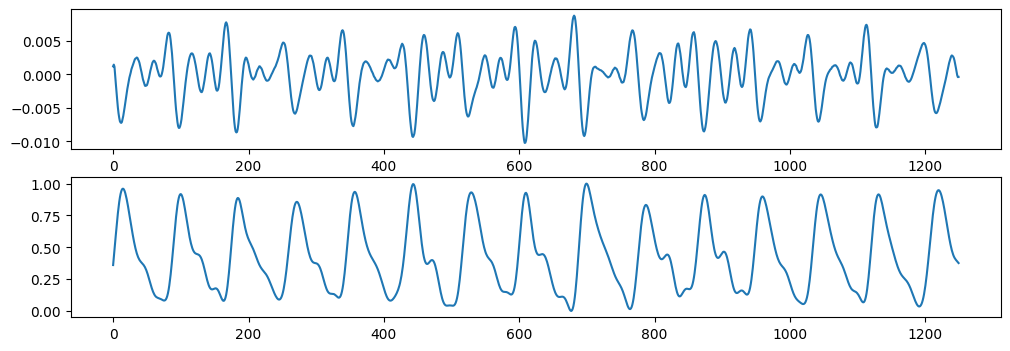

In [8]:
target = test_df[(test_df['ppg_morphology_class'] == -1)]
index = np.random.randint(0, len(target))
print(target.iloc[index]['signal_index'])
print(target.iloc[index][cols_to_display])
target_ppg = ppg[int(target.iloc[index]['signal_index'])]
target_apg = np.gradient(target_ppg)
target_apg = np.gradient(target_apg)
# plt.plot(target_ppg)
plt.subplots(2,1, figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(target_apg)
# plt.xlim(200, 600)
plt.subplot(2,1,2)
plt.plot(target_ppg)    
# plt.xlim(200, 600)

In [38]:
def _extract_ppg_cycles(df):
    """ Compute and save the ppg cycles in dataframe.
        This function updates filtered signal. 
    """
    def _extract_c(sig, fs, pk_th=0.6, remove_start_end=False):
        """ Wrapper for extract_cycle_check function. """
        try:
            cs, pks_norm, flag1, flag2, pks, vlys = features_extraction.extract_cycle_check(sig, fs, pk_th, remove_start_end)
        except:
            cs, pks_norm, flag1, flag2, pks, vlys = [], [], True, True, [], []
        return cs, pks_norm, flag1, flag2, pks, vlys

    c_ppg = Parallel(n_jobs=-1)(delayed(_extract_c)(sig, fs=125, remove_start_end=False) for sig in df.fsignal)

    for i, label in enumerate(['cs','pks_norm','ppg_f1','ppg_f2','ppg_pks','ppg_vlys']):
        df[label] = [val[i] for val in c_ppg]
    not_computed = ((df['ppg_pks'].map(len)==0) | (df['ppg_f2']))
    # cl_log.write(" - removed by not computed: {} \n".format((not_computed).sum()))
    df = df[~not_computed].reset_index(drop=True)

    return df

def _wrapper_compute_features_parallel(df):
    # 並列で処理する関数を定義
    def process_row(row):
        try:
            feat_name, feats = features_extraction.extract_feat_cycle(row.cs, row.pks_norm, fs=fs,mean=False)
            # feat_name = np.append(feat_name,"signal_index")
            # feats = np.append(feats,row.signal_index)
            return feat_name, feats
        except Exception as e:
            # print(e)
            return None  # 失敗した場合はNoneを返す
    
    # df.iterrows()の各行に対してprocess_rowを並列に適用
    # heads_feats = Parallel(n_jobs=-1)(
    #     delayed(process_row)(row) for _, row in df.iterrows()
    # )
    heads_feats = [process_row(row)for _,row in df.iterrows()]
    
    # Noneを取り除く
    heads_feats = [feat for feat in heads_feats if feat is not None]

    return heads_feats

In [39]:
# for j in trange(len(ppg_chunk)):
#     tmp = {"fsignal":[],"signal_index":[]}
#     tmp["fsignal"].append(ppg_chunk[j])
#     tmp["signal_index"].append(i+j)
#     a = pd.DataFrame(tmp)
#     df = pd.concat([df,a])
import features_extraction
from joblib import Parallel, delayed
fs = 125
# from features_extraction import _extract_ppg_cycles, _wrapper_compute_features_parallel
df = pd.DataFrame(columns=['fsignal','signal_index'])
dic = {"fsignal": [target_ppg], "signal_index":[0]}
df = pd.DataFrame(dic)
df = df.reset_index(drop=True)
df = _extract_ppg_cycles(df)
heads_feats = _wrapper_compute_features_parallel(df)
list_2 = []
for k,(h,f) in enumerate(heads_feats):
    if len(h)==0 or len(f) == 0:
        list_2.append(k)

list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats]
res_second = pd.DataFrame(list_series)
heads_feats_first = Parallel(n_jobs=-1)(delayed(features_extraction.extract_feat_original)(fsig, fs=fs, filtered = True, remove_start_end=False) for fsig in df['fsignal'])
list_2_1 = []
for l,(h,f) in enumerate(heads_feats_first):
    if len(h)==0 or len(f) == 0:
        list_2_1.append(l)
        

list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats_first]
res = pd.DataFrame(list_series)

template = pd.read_csv("columns_template.csv")['columns'].values
data_feats = res_second
keep_mask = ~data_feats.isna()['bd']

# data_feats = data_feats[keep_mask].reset_index(drop=True)
# df = df[keep_mask].reset_index(drop=True)

data_feats = data_feats.replace([np.inf, -np.inf], 0)
data_feats['signal_index']= data_feats['signal_index'].astype('int')


ValueError: Length of values (14) does not match length of index (98)

In [59]:
df

,fsignal,signal_index,cs,pks_norm,ppg_f1,ppg_f2,ppg_pks,ppg_vlys
0,"[0.3602954958674723, 0.4173956358914156, 0.476...",0,"[[0.3602954958674723, 0.4173956358914156, 0.47...","[14, 25, 21, 26, 24, 33, 27, 22, 22, 23, 37, 2...",False,False,"[14, 100, 184, 271, 357, 443, 529, 610, 699, 7...","[0, 75, 163, 245, 333, 410, 502, 588, 677, 764..."


In [40]:
heads_feats

[(array(['Tc', 'Ts', 'Td', 'Tsteepest', 'Steepest', 'TNegSteepest',
         'NegSteepest', 'TdiaRise', 'DiaRise', 'SteepDiaRise',
         'TSystoDiaRise', 'TdiaToEnd', 'Ratio', 'Ts_norm', 'Td_norm',
         'Tsteepest_norm', 'TNegSteepest_norm', 'TdiaRise_norm',
         'TSystoDiaRise_norm', 'TdiaToEnd_norm', 'SW25', 'SW25_norm',
         'DW25', 'DW25_norm', 'SWaddDW25', 'SWaddDW25_norm', 'DWdivSW25',
         'SW50', 'SW50_norm', 'DW50', 'DW50_norm', 'SWaddDW50',
         'SWaddDW50_norm', 'DWdivSW50', 'SW75', 'SW75_norm', 'DW75',
         'DW75_norm', 'SWaddDW75', 'SWaddDW75_norm', 'DWdivSW75', 'S1',
         'S2', 'S3', 'S4', 'AUCsys', 'AUCdia', 'S1_norm', 'S2_norm',
         'S3_norm', 'S4_norm', 'AUCsys_norm', 'AUCdia_norm', 'SQI_skew',
         'SQI_kurtosis', 'apg_a', 'apg_b', 'apg_c', 'apg_d', 'apg_e',
         'ppg_a', 'ppg_b', 'ppg_c', 'ppg_d', 'ppg_e', 'ratio_apg_b',
         'ratio_apg_c', 'ratio_apg_d', 'ratio_apg_e', 'ratio_ppg_b',
         'ratio_ppg_c', 'ratio_ppg_

In [41]:
h = heads_feats[0][0]
f = heads_feats[0][1]
h.shape, f.shape

((98,), (14, 98))

In [43]:
type(h)

numpy.ndarray

In [63]:
df["ppg_pks"].values[0]

[14, 100, 184, 271, 357, 443, 529, 610, 699, 787, 874, 959, 1045, 1131]

In [71]:
df["ppg_vlys"].values[0]

array([   0,   75,  163,  245,  333,  410,  502,  588,  677,  764,  837,
        936, 1019, 1108, 1191], dtype=int64)

In [74]:
f_a = f[:,np.where(h == 'apg_a')[0]].flatten()
f_b = f[:,np.where(h == 'apg_b')[0]].flatten()
f_c = f[:,np.where(h == 'apg_c')[0]].flatten()
f_d = f[:,np.where(h == 'apg_d')[0]].flatten()
f_e = f[:,np.where(h == 'apg_e')[0]].flatten()
# [a/fs,(b-a)/fs,(c-b)/fs,(d-c)/fs,(e-d)/fs]
T_a = f[:,np.where(h == 'T_a')[0]]
T_b = f[:,np.where(h == 'T_b')[0]]+T_a
T_c = f[:,np.where(h == 'T_c')[0]]+T_b
T_d = f[:,np.where(h == 'T_d')[0]]+T_c
T_e = f[:,np.where(h == 'T_e')[0]]+T_d
T_a = (T_a * fs).flatten() + df["ppg_vlys"].values[0][:-1]
T_b = (T_b * fs).flatten()+ df["ppg_vlys"].values[0][:-1]
T_c = (T_c * fs).flatten()+ df["ppg_vlys"].values[0][:-1]
T_d = (T_d * fs).flatten()+ df["ppg_vlys"].values[0][:-1]
T_e = (T_e * fs).flatten()+ df["ppg_vlys"].values[0][:-1]

In [68]:
f_a

array([0.00235717, 0.00619598, 0.0078364 , 0.00485635, 0.00668341,
       0.00479733, 0.00630004, 0.00719201, 0.00885239, 0.00660696,
       0.00307537, 0.0068602 , 0.00596829, 0.00742326])

In [55]:
target_apg = np.diff(np.diff(target_ppg))
target_apg.shape

(1248,)

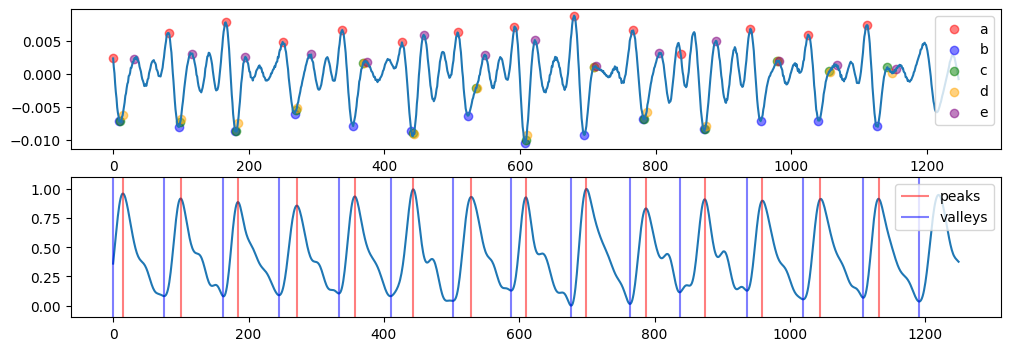

In [79]:
plt.subplots(2,1, figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(target_apg)
plt.scatter(T_a, f_a, color='red', label='a', alpha=0.5)
plt.scatter(T_b, f_b, color='blue', label='b', alpha=0.5)
plt.scatter(T_c, f_c, color='green', label='c', alpha=0.5)
plt.scatter(T_d, f_d, color='orange', label='d', alpha=0.5)
plt.scatter(T_e, f_e, color='purple', label='e',     alpha=0.5)
plt.legend()
# plt.xlim(200, 600)
plt.subplot(2,1,2)
plt.plot(target_ppg)
plt.vlines(np.array(df['ppg_pks'].values[0]), ymin=-0.1, ymax=1.1,label='peaks', color='red',alpha=0.5)
plt.vlines(np.array(df['ppg_vlys'].values[0]), ymin=-0.10, ymax=1.1, label='valleys', color='blue',alpha=0.5)    
plt.ylim(-0.1, 1.1)  
plt.legend()

## 0114 Honma

In [3]:
train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features3.parquet').drop('Unnamed: 0', axis=1, errors='ignore')  
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test3_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')


In [4]:
import numpy as np
import pandas as pd

def categorize_apg(df,
                   col_b="apg_b",
                   col_c="apg_c",
                   col_d="apg_d",
                   new_col="apg_category"):
    """
    APGのabcde振幅から形状カテゴリ(A〜E)を付与する
    """

    b = df[col_b]
    c = df[col_c]
    d = df[col_d]

    conditions = [
        # A
        (c > 0),

        # B
        ((b * 2/3 < c) & (c < 0) &
         (b * 2/3 < d) & (d < 0) &
         (b <= d)),

        # C（修正）
        (((c > b * 2/3) & (d < b * 2/3) & (b <= d)) |
         ((c > d * 2/3) & (b < d * 2/3) & (d <= b))),

        # D
        (((c < b * 2/3) & (d < b * 2/3) & (b <= d)) |
         ((c < d * 2/3) & (b < d * 2/3) & (d <= b))),
        
        # F（新設）
        ((c > b * 2/3) & (d > b * 2/3) &
         (c <= d * 2/3)),

        # E
        ((d * 2/3 < c) & (c < 0) &
         (d * 2/3 < b) & (b < 0) &
         (d <= b)),
        # G (独自に追加)
        ((d* 2/3 > b) &  (c < b* 2/3))
        
    ]

    choices = ["A", "B", "C", "D","X", "E", "Z"]

    df[new_col] = np.select(conditions, choices, default="Other")

    return df


In [42]:
train_df = categorize_apg(train_df)
test_df = categorize_apg(test_df)

In [47]:
train_df["apg_category"].value_counts()

apg_category
X        299713
B        151511
A         39857
C         12892
Other      6905
D          2260
E           581
Z           205
Name: count, dtype: int64

外れ値

In [ ]:
other_df = train_df[train_df["apg_category"] == "Other"]
len(other_df)
b = train_df["apg_b"]
c = train_df["apg_c"]
d = train_df["apg_d"]
train_df["_A"] = (c > 0)

train_df["_B"] = (
    (b * 2/3 < c) & (c < 0) &
    (b * 2/3 < d) & (d < 0) &
    (b < d)
)

train_df["_C"] = (
    ((c > b * 2/3) & (d < b * 2/3) & (b <= d)) |
    ((c > d * 2/3) & (b < d * 2/3) & (d <= b))
)

train_df["_D"] = (
    ((c > b * 2/3) & (d > b * 2/3) & (b <= d)) |
    ((c > d * 2/3) & (b > d * 2/3) & (d <= b))
)

train_df["_E"] = (
    (d * 2/3 < c) & (c < 0) &
    (d * 2/3 < b) & (b < 0) &
    (d < b)
)


In [11]:
other_df = train_df[
    ~(train_df["_A"] | train_df["_B"] | train_df["_C"] | train_df["_D"] | train_df["_E"])
]

In [12]:
other_df[["apg_b", "apg_c", "apg_d"]].apply(np.sign).value_counts()


apg_b  apg_c  apg_d
-1.0   -1.0   -1.0     2468
               1.0        9
Name: count, dtype: int64

In [50]:
region_df = pd.DataFrame({
    "c_vs_b": np.where(c > b*2/3, "c > 2/3 b", "c ≤ 2/3 b"),
    "d_vs_b": np.where(d > b*2/3, "d > 2/3 b", "d ≤ 2/3 b"),
    "c_vs_d": np.where(c > d*2/3, "c > 2/3 d", "c ≤ 2/3 d"),
    "category": train_df["apg_category"]
})

region_df[region_df["category"] == "Other"].value_counts()

c_vs_b     d_vs_b     c_vs_d     category
c > 2/3 b  d ≤ 2/3 b  c ≤ 2/3 d  Other       6478
c ≤ 2/3 b  d ≤ 2/3 b  c ≤ 2/3 d  Other        414
c > 2/3 b  d ≤ 2/3 b  c > 2/3 d  Other         13
Name: count, dtype: int64

In [29]:
train_df["cb_ratio"] = train_df["apg_c"] / train_df["apg_b"]
train_df["bd_ratio"] = train_df["apg_b"] / train_df["apg_d"]
train_df["db_ratio"] = train_df["apg_d"] / train_df["apg_b"]
train_df["cd_ratio"] = train_df["apg_c"] / train_df["apg_d"]

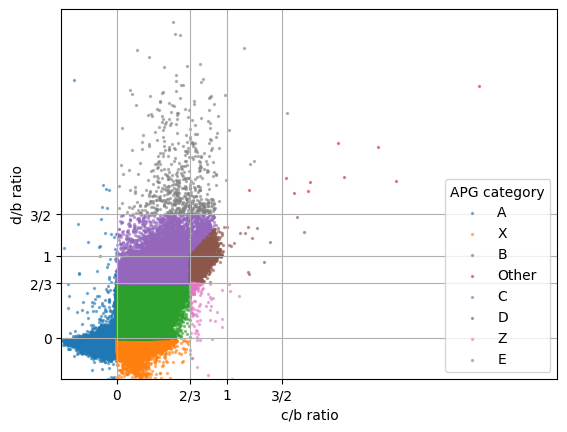

In [49]:
color_category = train_df["apg_category"]
c = color_category.astype('category').cat.codes
for cat in train_df["apg_category"].unique():
    sub = train_df[train_df["apg_category"] == cat]
    plt.scatter(
        sub["cb_ratio"],
        sub["db_ratio"],
        label=cat,
        alpha=0.5,
        s=2
    )
ticks = [0, 2/3, 1,3/2]

plt.xticks(ticks, ["0", "2/3", "1", "3/2"])
plt.yticks(ticks, ["0", "2/3", "1", "3/2"])
plt.xlabel("c/b ratio")
plt.ylabel("d/b ratio")
plt.legend(title="APG category")
plt.grid(True)
plt.xlim(-0.5,4)
plt.ylim(-0.5,4)
plt.show()

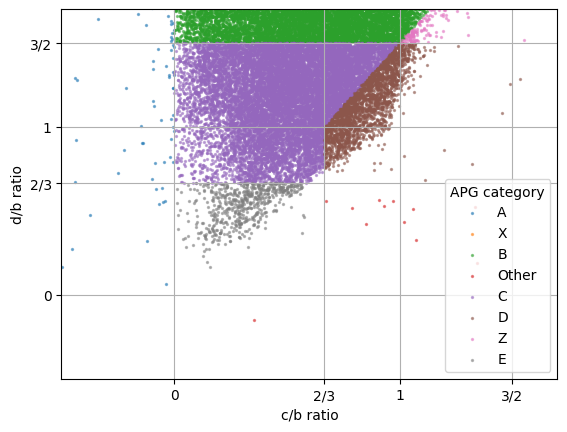

In [45]:
color_category = train_df["apg_category"]
c = color_category.astype('category').cat.codes
for cat in train_df["apg_category"].unique():
    sub = train_df[train_df["apg_category"] == cat]
    plt.scatter(
        sub["cd_ratio"],
        sub["bd_ratio"],
        label=cat,
        alpha=0.5,
        s=2
    )
ticks = [0, 2/3, 1,3/2]

plt.xticks(ticks, ["0", "2/3", "1", "3/2"])
plt.yticks(ticks, ["0", "2/3", "1", "3/2"])
plt.xlabel("c/b ratio")
plt.ylabel("d/b ratio")
plt.legend(title="APG category")
plt.grid(True)
plt.xlim(-0.5,1.7)
plt.ylim(-0.5,1.7)
plt.show()

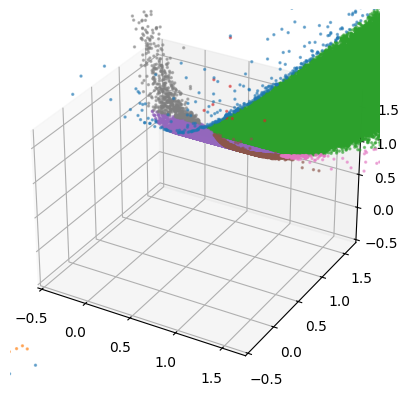

In [55]:
from mpl_toolkits.mplot3d import Axes3D
color_category = train_df["apg_category"]
c = color_category.astype('category').cat.codes
fig = plt.figure()
ax1 = fig.add_subplot(111 , projection='3d')
for cat in train_df["apg_category"].unique():
    sub = train_df[train_df["apg_category"] == cat]
    ax1.scatter3D(
        sub["cd_ratio"],
        sub["bd_ratio"],
        zs = sub["db_ratio"],
        zdir="z",
        label=cat,
        alpha=0.5,
        s=2
    )
    ax1.set_xlim(-0.5,1.7)
    ax1.set_ylim(-0.5,1.7)
    ax1.set_zlim(-0.5,1.7)

# classify

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score   

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GroupKFold

In [2]:
import numpy as np
import pandas as pd

def add_bp_class(df, sbp_col="sbp", dbp_col="dbp", new_col="bp_class"):
    """
    Add blood pressure class column based on SBP and DBP values.
    
    Categories:
        0: sbp < 120 and dbp < 80
        1: 120 <= sbp < 140 or 80 <= dbp < 90
        2: sbp >= 140 or dbp >= 90
    """
    
    conditions = [
        (df[sbp_col] < 120) & (df[dbp_col] < 80),
        ((df[sbp_col] >= 120) & (df[sbp_col] < 140)) | ((df[dbp_col] >= 80) & (df[dbp_col] < 90)),
        (df[sbp_col] >= 140) | (df[dbp_col] >= 90)
    ]
    
    values = [0, 1, 2]
    
    df[new_col] = np.select(conditions, values, default=np.nan).astype(int)
    return df


def add_sbp_class(df, col_name='sbp', new_col='sbp_class'):
    """
    SBP値に応じてクラスを付与する関数
      - sbp < 100 → 0
      - 100 <= sbp < 140 → 1
      - sbp >= 140 → 2

    Parameters
    ----------
    df : pd.DataFrame
        SBP列を含むデータフレーム
    col_name : str, default 'sbp'
        SBPの列名
    new_col : str, default 'sbp_class'
        新しい列名

    Returns
    -------
    df : pd.DataFrame
        新しい列が追加されたDataFrame
    """
    conditions = [
        df[col_name] < 100,
        (df[col_name] >= 100) & (df[col_name] < 140),
        df[col_name] >= 140
    ]
    values = [0, 1, 2]
    df[new_col] = np.select(conditions, values).astype('int')
    return df

def add_sbp_class_2(df, col_name='sbp',boundary=120, new_col='sbp_class'):
    """
    SBP値に応じてクラスを付与する関数
      - sbp < boundary → 0
      - sbp >= boundary → 2

    Parameters
    ----------
    df : pd.DataFrame
        SBP列を含むデータフレーム
    col_name : str, default 'sbp'
        SBPの列名
    new_col : str, default 'sbp_class'
        新しい列名

    Returns
    -------
    df : pd.DataFrame
        新しい列が追加されたDataFrame
    """
    conditions = [
        df[col_name] < boundary,
        df[col_name] >= boundary
    ]
    values = [0, 2]
    df[new_col] = np.select(conditions, values).astype('int')
    return df
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.utils.class_weight import compute_sample_weight
def get_groupkf(df,k=5, group_col='subject',y_col='sbp_class', random_state=42,get_holdout=False,remove_cols=True,return_raw_train=False):
    """
    StratifiedGroupKFoldを用いてデータを分割する関数
    Parameters
    ----------
    df : pd.DataFrame
        分割対象のデータフレーム
    k : int, default 5
        分割数
    group_col : str, default 'subject'
        グループ化に使用する列名
    y_col : str, default 'sbp_class'
        ラベル列名 
    random_state : int, default 42
        乱数シード
    get_holdout : bool, default False
        ホールドアウトセットを取得するかどうか
    Returns
    -------
    folds : list of tuples
        各フォールドのデータセットのリスト
        get_holdoutがTrueの場合、各タプルは(train_data, val_data, hold_data)となる
        get_holdoutがFalseの場合、各タプルは(train_data, hold_data)となる
    """
    gkf = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=random_state)
    gkf2 = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=random_state)
    folds = []
    for use_idx, hold_idx in gkf.split(df,df[y_col], groups=df[group_col]):
        u = df.iloc[use_idx]
        h = df.iloc[hold_idx]
        if get_holdout:
            for train_idx, val_idx in gkf2.split(u,u[y_col], groups=u[group_col]):
                t = u.iloc[train_idx]
                v = u.iloc[val_idx]
                break
            print(set(t[group_col]) & set(v[group_col])& set(h[group_col]))
            train_data = get_dataset(t, weight='balanced',return_raw=return_raw_train,y_col=y_col, remove_cols=remove_cols, )
            val_data = get_dataset(v,return_raw=True)
        else:
            print(set(u[group_col]) & set(h[group_col]))
            train_data = get_dataset(u, weight='balanced', return_raw=return_raw_train,y_col=y_col, remove_cols=remove_cols,)
        hold_data = get_dataset(h,return_raw=True,y_col=y_col, remove_cols=remove_cols)
        if get_holdout:
            folds.append((train_data, val_data, hold_data))
        else:
            folds.append((train_data, hold_data))
    return folds
def get_dataset(df,weight=None,return_raw=False,y_col='sbp_class', remove_cols=True):
    """
    Daframeから不要な列を除いてLightGBM用のデータセットを作成する関数
    Parameters
    ----------
    df : pd.DataFrame
        特徴量とラベルを含むデータフレーム

    weight : str or None, default None
        クラス重みの指定。Noneの場合は重みなし、'balanced'の場合はバランス調整された重みを使用。
    Returns
    -------
    dataset : lgb.Dataset
        LightGBM用のデータセット
    """ 
    if remove_cols:
        X = df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class','sbp_bin',"bp_class"],axis=1, errors='ignore')
    else:
        X = df.drop(['signal_index'], axis=1, errors='ignore')
    Y = df[y_col]
    if weight is not None:
        weights = compute_sample_weight(class_weight=weight, y=Y)
        dataset = lgb.Dataset(X, label=Y, weight=weights)
    else:
        dataset = lgb.Dataset(X, label=Y)
    if return_raw:
        return [X, Y] 
    return dataset
    
def add_class(classes=3, boundary=120):
    train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features3.parquet')
    # test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
    test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test3_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  

    train_df=train_df.drop('Unnamed: 0', axis=1, errors='ignore')
    test_df=test_df.drop('Unnamed: 0', axis=1, errors='ignore')  
    if boundary is None:
        # print("1",boundary)
        train_df = add_sbp_class(train_df)
        test_df = add_sbp_class(test_df)
        print(test_df["sbp_class"].nunique())
    else:
        # print("2",boundary,classes)
        train_df = add_sbp_class_2(train_df, boundary=boundary)
        test_df = add_sbp_class_2(test_df, boundary=boundary)
    if classes==2:
        # print("2",boundary,classes)
        train_df = train_df[train_df['sbp_class'] != 1]
        test_df = test_df[test_df['sbp_class'] != 1]
        train_df['sbp_class'] = train_df['sbp_class'] // 2 
        test_df['sbp_class'] = test_df['sbp_class'] // 2
    return train_df, test_df

def add_random_class(classes=2):
    train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features.parquet')
    # test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
    test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  

    train_df=train_df.drop('Unnamed: 0', axis=1, errors='ignore')
    test_df=test_df.drop('Unnamed: 0', axis=1, errors='ignore')  
    np.random.seed(42)
    train_df['sbp_class'] = np.random.randint(0, classes, size=len(train_df))
    test_df['sbp_class'] = np.random.randint(0, classes, size=len(test_df))
    train_df['bp_class'] = np.random.randint(0, classes, size=len(train_df))
    test_df['bp_class'] = np.random.randint(0, classes, size=len(test_df))
    return train_df, test_df

In [5]:
train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features3.parquet').drop('Unnamed: 0', axis=1, errors='ignore')
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test3_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
train_df = categorize_apg(train_df)
test_df = categorize_apg(test_df)
print(train_df.shape, test_df.shape)
train_df = add_bp_class(train_df)
test_df = add_bp_class(test_df)


(513924, 104) (102896, 103)


In [13]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
# train_df, test_df = add_class(classes=3, boundary=None)
results3 = []
f=0
# test_X,test_Y = get_dataset(test_df, return_raw=True)
category = ['A','B','C','D','E','X','Z',"Other"]
gkf = GroupKFold(n_splits=2)
for cat in category: 
    tmp_df_test = test_df[test_df['bp_class'] != 2]
    tmp_df_test = tmp_df_test[tmp_df_test['apg_category'] == cat].drop("apg_category", axis=1, errors='ignore')
    tmp_df_train = train_df[train_df['bp_class'] != 2]
    tmp_df_train = tmp_df_train[tmp_df_train['apg_category'] == cat].drop("apg_category", axis=1, errors='ignore')
    test_X,test_Y = get_dataset(tmp_df_test, return_raw=True,y_col='bp_class')
    print(f"Category: {cat}, Train samples: {len(tmp_df_train)}, Test samples: {len(tmp_df_test)}")
    for train_idx, val_idx in gkf.split(tmp_df_train, groups=tmp_df_train['subject']):
        train_X = tmp_df_train.iloc[train_idx].drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class',"sbp_bin","bp_class"],axis=1,errors='ignore')
        train_Y = tmp_df_train.iloc[train_idx]['bp_class']
        val_Y = tmp_df_train.iloc[val_idx]['bp_class']
        val_X = tmp_df_train.iloc[val_idx].drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class',"sbp_bin","bp_class"],axis=1,errors='ignore')
        params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        "min_data_in_leaf": 200,
        'num_leaves': 31,
        'max_depth': -1,
        'verbose': -1,
        'random_state': 42,
        }
        importance_df = pd.DataFrame({"feature": test_X.columns})
        if test_Y.ndim>1:
            # softlabel
            params['objective'] = 'cross_entropy'
            params['metric'] = 'cross_entropy'
            params['num_class'] =1
        elif test_Y.nunique() > 2:
            params['objective'] = 'multiclass'
            params['metric'] = 'multi_error'
            params['num_class'] = test_Y.nunique()
        # --- モデル学習 ---
        lgb_train = lgb.Dataset(train_X, label=train_Y,weight=compute_sample_weight(class_weight='balanced', y=train_Y)) 
        lgb_val = lgb.Dataset(val_X, label=val_Y) 
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_val],
            valid_names=['train', 'val'],
            num_boost_round=2000,
            callbacks=[lgb.early_stopping(stopping_rounds=50,verbose=False)],
        )
        # --- 予測 ---
        pred_Y_prob = model.predict(test_X, num_iteration=model.best_iteration)
        pred_Y_prob_val = model.predict(val_X, num_iteration=model.best_iteration)
        pred_Y_test = np.argmax(pred_Y_prob, axis=1) if test_Y.nunique() > 2 else (pred_Y_prob >= 0.5).astype(int)
        pred_Y_val = np.argmax(pred_Y_prob_val, axis=1) if val_Y.nunique() > 2 else (pred_Y_prob_val >= 0.5).astype(int)
        # --- 評価 ---
        acc = accuracy_score(test_Y, pred_Y_test)
        pre = precision_score(test_Y, pred_Y_test, average='macro')
        rec = recall_score(test_Y, pred_Y_test, average='macro')
        cm = confusion_matrix(test_Y, pred_Y_test)
        f1 = f1_score(test_Y, pred_Y_test,average='macro')
        # --- Feature Importance ---
        importance_df[f'importance_fold{f}'] = model.feature_importance(importance_type='gain')
        # --- 結果保存 ---
        res = {"accuracy" :acc,
            "f1":f1,
            "precision": pre,
            "recall": rec,
            "cm":cm,
            "fold":f,
            "pred_test_prob":pred_Y_prob,
            "pred_val_prob":pred_Y_prob_val,
            "pred_test":pred_Y_test,
            "pred_val":pred_Y_val,
            "true":test_Y
            } 
        results3.append(res)
        print(f"Fold {f} - F1: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {pre:.4f}, Recall: {rec:.4f}")
        f+=1
    # break
# --- 可視化 ---

Category: A, Train samples: 35332, Test samples: 7442
Fold 0 - F1: 0.5927, Accuracy: 0.6625, Precision: 0.5972, Recall: 0.5904
Fold 1 - F1: 0.6361, Accuracy: 0.6891, Precision: 0.6366, Recall: 0.6356
Category: B, Train samples: 112763, Test samples: 27071
Fold 2 - F1: 0.6002, Accuracy: 0.6009, Precision: 0.6014, Recall: 0.6023
Fold 3 - F1: 0.6024, Accuracy: 0.6027, Precision: 0.6045, Recall: 0.6053
Category: C, Train samples: 7027, Test samples: 1471
Fold 4 - F1: 0.5273, Accuracy: 0.5303, Precision: 0.5289, Recall: 0.5285
Fold 5 - F1: 0.5575, Accuracy: 0.5738, Precision: 0.5788, Recall: 0.5689
Category: D, Train samples: 1470, Test samples: 326
Fold 6 - F1: 0.6808, Accuracy: 0.7025, Precision: 0.7326, Recall: 0.6870
Fold 7 - F1: 0.5174, Accuracy: 0.5429, Precision: 0.5338, Recall: 0.5289
Category: E, Train samples: 325, Test samples: 47
Fold 8 - F1: 0.4268, Accuracy: 0.7447, Precision: 0.3723, Recall: 0.5000
Fold 9 - F1: 0.4268, Accuracy: 0.7447, Precision: 0.3723, Recall: 0.5000


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Category: X, Train samples: 247730, Test samples: 52300
Fold 10 - F1: 0.6147, Accuracy: 0.6234, Precision: 0.6211, Recall: 0.6316
Fold 11 - F1: 0.6104, Accuracy: 0.6181, Precision: 0.6184, Recall: 0.6288
Category: Z, Train samples: 173, Test samples: 41
Fold 12 - F1: 0.1961, Accuracy: 0.2439, Precision: 0.1220, Recall: 0.5000
Fold 13 - F1: 0.1961, Accuracy: 0.2439, Precision: 0.1220, Recall: 0.5000


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Category: Other, Train samples: 6332, Test samples: 1499
Fold 14 - F1: 0.4460, Accuracy: 0.7558, Precision: 0.4768, Recall: 0.4336
Fold 15 - F1: 0.5653, Accuracy: 0.8279, Precision: 0.5574, Recall: 0.6444
